# Linear Regression: Finding the Best of the Best (Lines of Fit)
In this short notebook, we will demonstrate a simple simple supervised technique for finding trends in data.

Regression models are a class of models which seek relationships between an independent variable and some number of dependent variables. Linear regression models, a subset, assume that said relationship is linear in nature, that is, that it can be described as a linear combination of input variables $ x_{0} \ldots x_{n} $:

$$ y = w_{0}x_{0} + w_{1}x_{1} + w_{2}x_{2}  \ldots w_{n}x_{n} $$

$ w_{0} \ldots w_{n}x_{n} $ denote parameters to be estimated and iteratively refined. The goal is to 'nudge' our hypothesized line by adjusting these values until overall cost is minimized.  This qualifies as a "supervised" technique because predictions are extrapolated from known, prior values (labels). 

Please also note that we can define two main types: 

(1) Simple: entails only one independent variable ($ x $). 

(2) Multiple: entails any number of independent variables greater than one. 

In this tutorial, we'll focus on (2). The model for this problem will follow the equation $ y = w_{0}x_{0} + w_{1}x_{1} $, with $ x_0 $ set to a constant value of one. We can rename $ w_{1} $ as $ m $ and $ w_{0} $ as $ b $ as a way of making the equation look more familiar, thus yielding a model of the form $ y = mx + b $. Let's begin. 

### A Little Housekeeping
We will first import all dependencies and set up our programming environment. 

In [64]:
# Reset the workspace, forcibly deleting all existing variables 
%reset -f

In [65]:
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.dates import DateFormatter, AutoDateFormatter
from sklearn import preprocessing

%matplotlib inline

### Importing the Data
Linear regression can be performed on any dataset, regardless of whether a clear upward or downward trend can be extrapolated. However, for the sake of demonstration, we will choose a set with a clear and consistent tendency. Please note that stock prediction is notoriously *not* the sort of problem that linear regression is a good fit for - the behavior of equities and indexes is notoriously stochastic, or unpredictable, and based on a variety of random factors. To presume that the value of a stock will continue to follow a trend simply because that has been the case in the past is a faulty view. 

With this in mind, the dataset of all-time historical stock data for Merck & Co (MRK) is suitable for simply demonstrating a technique. Our set includes years 1970 to 2020, during which time this stock has enjoyed a substantial increase in value. It was first listed on the Down Jones Industrial Average in 1979. Source: Yahoo Finance (https://finance.yahoo.com/quote/MRK/history?p=MRK)

We'll first import the data to a Pandas dataframe, preview the first handful of rows, and print a few statistics in order to get a feel for the data. 

Please note that the file, which is .csv format, will be saved in a directory named 'Data.'

In [66]:
df = pd.read_csv('Data/MRK.csv',
                parse_dates=['Date'])

df.head() # Preview the first few rows of data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,1.565972,1.565972,1.541667,1.545139,0.352593,475200
1,1970-01-05,1.545139,1.555556,1.531250,1.536458,0.350612,669600
2,1970-01-06,1.536458,1.548611,1.527778,1.548611,0.353385,568800
3,1970-01-07,1.548611,1.562500,1.531250,1.534722,0.350216,892800
4,1970-01-08,1.538194,1.555556,1.538194,1.545139,0.352593,496800


We can also check the data types of each column:

In [67]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Importantly, note that the type of entries in the 'Date' field are of type datetime64[ns]. This is NumPy's functional equivalent of Python's builtin datetime function. datetime64[ns] encodes dates as 64-bit integers, which are very compact and good for vectorization. [ns] is a format code that specifies precision to the nanosecond. 

In [68]:
print('Dataframe shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data features:', df.shape[1])
print('Number of dimensions:', df.ndim)

Dataframe shape: (12778, 7)
Number of data examples: 12778
Number of data features: 7
Number of dimensions: 2


Because it may be time costly to plot almost 13,000 points, we will take every fifth data point and omit all others. The overall trend and result of our regression analysis will end up essentially the same. 

In [69]:
df = df.iloc[::5, :] # Include every fifth row
print('Dataframe shape:', df.shape)
print('Number of data examples:', df.shape[0])
print('Number of data features:', df.shape[1])
print('Number of dimensions:', df.ndim)

Dataframe shape: (2556, 7)
Number of data examples: 2556
Number of data features: 7
Number of dimensions: 2


We should also check for missing values. There are none, as evidenced by the code below:

In [70]:
print('Presence of Any Missing Value, by Column: \n')
print(df.isnull().any(), '\n')

print('Just to Confirm - Sum of Missing Values, by Column: \n')
print(df.isnull().sum())

Presence of Any Missing Value, by Column: 

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool 

Just to Confirm - Sum of Missing Values, by Column: 

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


It can also be useful to display summary statistics. 

In [71]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2.556000e+03
mean,29.052236,29.352241,28.757661,29.068578,18.613251,7.044703e+06
std,25.784099,26.056528,25.520080,25.805094,20.460078,6.082407e+06
min,1.090278,1.097222,1.076389,1.076389,0.247066,2.232000e+05
25%,2.431424,2.457465,2.415799,2.436632,0.719148,2.892650e+06
50%,25.000000,25.187500,24.781250,24.937500,10.072225,5.536700e+06
75%,50.570000,51.070000,50.045626,50.679998,29.361950,9.522075e+06
max,92.812500,93.250000,91.269997,92.687500,90.172379,6.659160e+07


In [72]:
df.index

RangeIndex(start=0, stop=12778, step=5)

They say a picture is worth a thousand words. We'll now visualize the data using matplotlib, which can easily pull information from a Pandas dataframe. 

A small caveat is that the independent (x) and dependent (y) variables must be specified in order to use the df.plot() function. For that, it is trivially easy to simply look at the column headers displayed in df.head(). 

Another handy way to access these headers is by calling the columns attribute of the dataframe using df.columns, as seen below. 

In [73]:
df.columns # Displays column headers needed for plotting

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

We will plot stock close values from all time (1970 until present) with date as the independent variable. 

<AxesSubplot:title={'center':'MRK Close Value vs. Date, 1970 - 2020'}, xlabel='Date', ylabel='Close'>

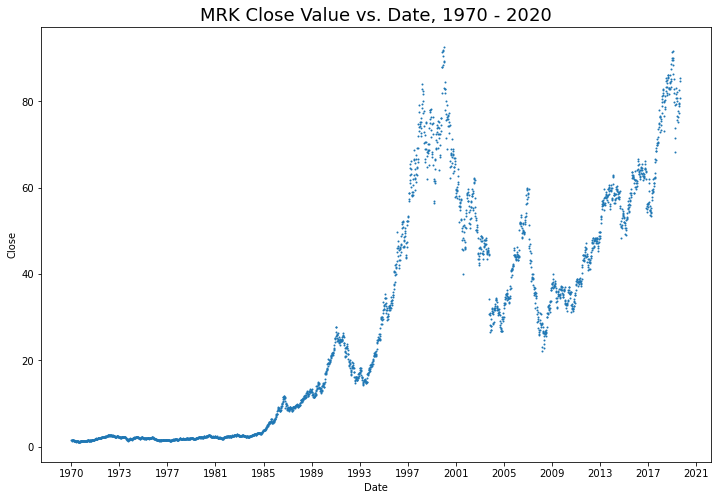

In [74]:
# TODO: format to match other plots 

fig, ax = plt.subplots(figsize=(12,8), facecolor = 'white') # Sets plot size and color behind axes
ax.set_title('MRK Close Value vs. Date, 1970 - 2020', fontsize=18) # Title
date_form = DateFormatter("%Y") # Formats x axis dates
ax.xaxis.set_major_formatter(date_form)
loc = plticker.MultipleLocator(base=365.0*4) # Set interval / frequency of x axis ticks
ax.xaxis.set_major_locator(loc) 
df.plot(kind = 'scatter', x = 'Date', y = 'Close', ax = ax, s = 1) # Plot data

## Data Prep

### Format 'Date' Column
As you can see in the code below, the entries contained in the 'Date' column of the dataframe df are of the type pandas Timestamp. 

In [75]:
print('Date entry:', df['Date'][0])
print('Date entry type:', type(df['Date'][0]))

Date entry: 1970-01-02 00:00:00
Date entry type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Linear regression methods do not handle this format well, so we will start by converting each of these timestamps into an ordinal value, that is, a number to represent the date and time. 

This is relatively straightforward to do using the toordinal function within the datetime module. Simply put, this function assigns every day from January 1st of the year 1 to December 31st of the 9,999th year its own number. 

In [76]:
x = pd.to_datetime(df['Date'])
x = x.map(dt.datetime.toordinal).to_numpy()
print(type(x))

<class 'numpy.ndarray'>


The change from datetime to ordinal value should be apparent in dataframe dtypes:

In [77]:
type(x[0])

numpy.int64

Now that everything has been nicely converted, we'll define the dependent variable and adjust dimensions to allow for matrix multiplication. 

In [78]:
y = df['Close'].to_numpy()
m = len(x)

# Add a dimension to x and y to allow array multiplication later
x, y = np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)

print('\nx.shape:', x.shape, 'type:', type(x))
print('y.shape:', y.shape, 'type:', type(y), '\n')

print('x, containing converted datetimes: \n\n', x)


x.shape: (2556, 1) type: <class 'numpy.ndarray'>
y.shape: (2556, 1) type: <class 'numpy.ndarray'> 

x, containing converted datetimes: 

 [[719164]
 [719171]
 [719178]
 ...
 [737647]
 [737654]
 [737661]]


### Normalize x values for more efficient convergence 
After normalization, values will be in the range [0,1]. 

In [79]:
print('Close values range:', (max(x) - min(x)))
x_norm = preprocessing.scale(x)

Close values range: [18497]


# Defining Cost

Finding the line of "best fit" requires a defintion of "best." A metric commonly used for this task is the vertical deviation, or the vertical distance as measured from a hypothesized line to each data point in the set. Least squares regression is a popular method which minimizes the sum of all of these vertical deviations, squared -  

$$ J(w_{0}, w_{1}) = \frac{1}{2m}\sum_{m}^{i=1}(h(x^{(i)}) - y^ {(i)}))^{2} $$

In [80]:
# TODO : return J as a float 

def compute_cost(hypothesis, y):
    """
    Calculate the cost function. 
    
    To be run repeatedly as gradient descent executes.

    Args:
        hypothesis (numpy.ndarray): array of size (m, 1) containing hypothesized target values 
        y (numpy.ndarray): array of size (m, 1) containing target values

    Returns:
        J (numpy.float64): cost, or the root mean squared error between hypothesis and target solution (y)
        
    """      
    num_samples = len(y)
    J = (1/num_samples) * sum((hypothesis - y) ** 2)

    return J

# Define Hypothesis Plotting Function

In [81]:
def plot_hypothesis(hypothesis, x, weights):
    """
    Plots, and displays the function of, a line. 

    Args:
        hypothesis (numpy.ndarray): array of size (m, 1) containing hypothesized target values 
        x (numpy.ndarray): array of size (2556, 1) containing x data
        weights (numpy.ndarray): array of size (2, 1) for linear regression in two dimensions. 
            weights[0] is the value of the intercept, b; weights[1] is the slope parameter, m. 
    
    Returns:
        None

    """ 
    h = ax.plot(x, hypothesis)
    
    w0 = "{:.2f}".format(round(weights[0][0], 2))
    w1 = "{:.2f}".format(round(weights[1][0], 2))
    legend_text = str(w1 + "x" + " + " + w0)  
    
    ax.legend(h, ['Hypothesis: ' + legend_text], fontsize='xx-large', loc='upper left')
    fig.canvas.draw()

# Define Gradient Descent Function
Gradient descent is a function that finds the minimum (local, or global - more on that later) of a function by repetitively calculating its gradient, and moving in the direction that it stipulates will lead to the lowest nearby point. There's a lot of calculus here, and to follow this proof requires knowledge of partial derivatives. If you don't know calculus, you can skip this part and move on, but in the long run, these topics are crucial for an in-depth understanding. 

Please note that m = len(x), or the number of samples in the data set. 

Earlier, we defined the cost function: 

$$ J(w_{0}, w_{1}) = \frac{1}{2m}\sum_{m}^{i=1}(h(x^{(i)}) - y^ {(i)}))^{2} $$

Hypothesis function: 

$$ h(x) = w_{1}x + w_{0} $$

Substitute the hypothesis function $h(x) $ into the cost function, $ J $, in order to optimize $ J $ with respect to the parameters contained within $ h(x) $; recall that these are the weights, $ w_0 $ and $ w_1 $: 

$$ J = \frac{1}{2m} \sum_{m}^{i=1} ((w_{1}x + w_{0})) - y^ {(i)})^{2} $$


Since we are trying to optimize the weights, a.k.a. parameters of the function (which are demarcated by $ w_0 $ and $ w_1 $), we will take the gradient of the cost function with respect to each of these two parameters. 

Note that the gradient is simply a vector of partial derivates with respect to each component. Thus, 

* $ \nabla_{\mathbf{w_0}} J = \frac{\partial }{\partial w_0} J(w_0, w_1) = \frac{2}{2m} \sum((w_1x^{(i)} + w_0) - y^{(i)})\cdot (1))$

* $ \nabla_{\mathbf{w_1}} J = \frac{\partial }{\partial w_1} J(w_0, w_1) = \frac{2}{2m} \sum((w_1x^{(i)} + w_0) - y^{(i)})\cdot (x^{(i)}) $

Note that the partial derivate of $ J $ with respect to each parameter involves the Chain Rule. 

Repeat until convergence: 

* $ w_{0new} := w_{0old} - \alpha \frac{\partial }{\partial w_0} J(w_0, w_1) $

  $ = w_{0old} - \alpha \frac{2}{2m} \sum((w_1x^{(i)} + w_0) - y^{(i)})\cdot (1) $

and 


* $ w_{1new} := w_{1old} - \alpha \frac{\partial }{\partial w_1} J(w_0, w_1) $

* $ w_{1new} := w_{1old} - \alpha \frac{2}{2m} \sum((w_1x^{(i)} + w_0) - y^{(i)})\cdot (x^{(i)}) $

In [82]:
def gradient_descent(X, y, weights, learning_rate, epochs):
    """
    Iteratively compute and minimize cost by updating weights. 

    Args:
        X (numpy.ndarray): shape (len(x), 2), where X[:,1:2] equals data values
            and X[:, 0:1] is a column of ones that makes array dimensions 
            agreeable for matrix multiplication. 
        y (numpy.ndarray): size (m, 1) array containing target values 
        weights (numpy.ndarray): array of size (2, 1) for linear regression in two dimensions. 
            weights[0] is the value of the intercept, b; weights[1] is the slope parameter, m. 
        learning_rate (float): dictates 'step size' used for gradient descent. Values that are too small may take 
            a very long time to converge; very large values may cause gradient descent to diverge
        epochs (int): set desired number of iterations. A larger value requires more time to run and may return results
            with higher confidence. 

    Returns:
        hypothesis (numpy.ndarray): array of size (m, 1) containing hypothesized target values 
        weights (numpy.ndarray): array of size (2, 1) containing new weights after update via gradient descent. 
        cost_history (numpy.ndarray): contains cost J calculated during each epoch. 
            Array size will thus be (epochs, 1)

    """   
    num_samples = len(y)
    cost_history = np.zeros([epochs, 1])

    for i in range(epochs):
        hypothesis = np.matmul(X, weights)
        
        # Find gradient of cost function J with respect to each of the two parameters (w1 and w2)
        gradient_wrt_weight0 = (1/num_samples) * sum(hypothesis - y) * 1
        gradient_wrt_weight1 = (1/num_samples) * sum((hypothesis - y) * X[:,1:2])
        
        weight0_new = weights[0] - learning_rate * gradient_wrt_weight0
        weight1_new = weights[1] - learning_rate * gradient_wrt_weight1
        
        weights[0] = weight0_new
        weights[1] = weight1_new
        
        # print('W0:', weights[0])
        # print('W1:', weights[1])
        
        cost = compute_cost(hypothesis, y)
        cost_history[i] = cost
        # print('Cost:', cost)
        
# TODO - update input from x to a function of X        
        plot_hypothesis(hypothesis, x, weights)
        
        if i != epochs - 1:
            del ax.lines[0] # erase line before next iteration, as long as there will be more

    return hypothesis, weights, cost_history

# Main Program
First, choose values for hyperparameters learning rate and number of epochs. There is no definitive rule for choosing these values; experienced practitioners may be able to "intuit" those that will converge faster. For others, it can require empirical observation and patience. 

We will also initialize parameters (weights) using Numpy's builtin random function. 

We need also to create a new array, ` X `, which contains ones in its first column, and the x data in its second. We do this so that the values in x can be matrix multiplied against those in the weights array without raising a dimensionality disagreement. 

As a quick aside, this is necessary because, in linear algebra, the 'inner' dimensions of matrices that are multipled must match. 

For example, the following is valid: [2 x 3]\*[3 * 1] → [2 x 1] matrix

This is not: [2 x 3]\*[4 x 5], because 3 ≠ 4.

In [83]:
learning_rate = 0.007 # Also called 'alpha'
epochs = 500 # As desired
weights = np.random.rand(2,1) # weights[0] is intercept b; weights[1] is slope m

X = np.ones([m, 2])
X[:, 1:2] = x_norm

print('Y intercept:', weights[0][0])
print('Slope:', weights[1][0])

Y intercept: 0.4506785385955555
Slope: 0.17664022012558955


<IPython.core.display.Javascript object>


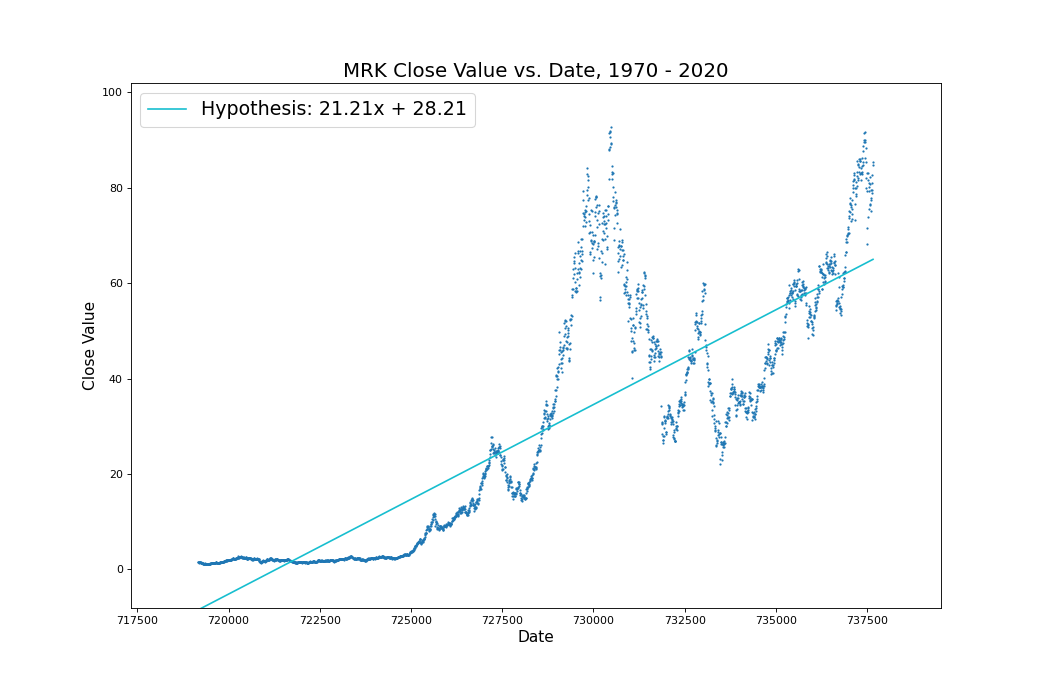

In [84]:
%matplotlib notebook
plt.ion()

x_margin = (max(x) - min(x))*.10
y_margin = (max(y) - min(y))*.10

fig, ax = plt.subplots(figsize=(12,8), facecolor = 'white') # Sets plot size and color behind axes
ax.set_title('MRK Close Value vs. Date, 1970 - 2020', fontsize = 18)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Close Value', fontsize = 14)
plt.xlim(min(x) - x_margin, max(x) + x_margin)
plt.ylim(min(y) - y_margin, max(y) + y_margin)
plt.scatter(x, y, s=1)

hypothesis, weights, cost_history = gradient_descent(X, y, weights, learning_rate, epochs)

# Cautions and Final Words

As you can see, the model found the line of best fit. Regression can be a powerful tool for predicting general tendencies over the time, though with the caveat of a few weaknesses. This method is, for example, extremely sensitive to outliers, which may skew cost calculations. 

In any scenario, additionally, ts usefulness is also inversely correlated with the validity of the assumptions on which its use is based. Does any correlation exist in the data to  begin with? If present, could it more powerfully be described with $ n^{th} $ degree polynomial regression instead? These are considerations that are crucial to model selection, and should form the basis of preliminary data exploration. 